In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
path = "/Users/atalianb/Documents/data_LBSG/Blok_McGaugh_& _Rubin_(2001)/"

In [3]:
##Values for epsilon and the field mass from the chi^2,
##taking just l=0 or l=1 for the data set ESO3020120
####
eps_l0 = 3.8e-4
eps_l1 = 3.7e-4
m_a_l0 = 6.2e-24#eV/c^2
m_a_l1 = 8.8e-24#eV/c^2
#####Gravitational Constant
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10.# End of integration
step_0 = 0.5#Step to integrate from x0_0 until xf_0v1 is reached
##l=0
u1_0 = 0.63173215# 1st trial value of unknown init. cond.
u2_0 = 1.28125868# 2nd trial value of unknown init. cond.
u_0 = np.array([u1_0, u2_0])
###l=1 
u1_1 = -3.7# 1st trial value of unknown init. cond.
u2_1 = -2.2# 2nd trial value of unknown init. cond.
u_1 = np.array([u1_1, u2_1])

In [4]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [5]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        x_list.append(x)
        root = optimize.root(res,u)
        u = root.x
        root_temp = optimize.root(res,root.x)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [6]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [7]:
def f0(x,y):
    l = 0.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F
def f1(x,y):
    l = 1.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [8]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [9]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [10]:
def rescaling(phi_0,l):
    lmbd = (1./phi_0)**(1/(l+2.))
    return lmbd

In [12]:
def Vc_xy_phi(r,m_a,eps,phi0,func,s_begin,l):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(func,s_begin,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    Xl = X0*rescaling(phi0,l)
    M_r0 = Mass_func(Xl,Y0*phi0,l)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(Xl,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(Xl,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,Vc2_total
    else:
        return X0_units,Vc2_r0

In [13]:
ESO3020120 = np.loadtxt(path+'ESO3020120.dat')

In [14]:
vecRp_ESO3020120 = np.array([row[1] for row in ESO3020120])# galactocentric distance [kpc]
vecvRp_ESO3020120 = np.array([row[5] for row in ESO3020120])# rotation velocity [km/s]
vecerrvRp_ESO3020120 = np.array([row[6] for row in ESO3020120])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

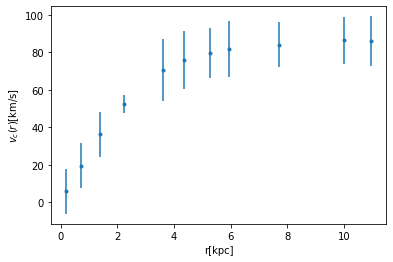

In [15]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Grid with $\phi_{0,\ell = 0}$ and $\phi_{0,\ell =1}$

In [21]:
def Vc_xi2_phi(r,m_a,eps,phi0,func,u_begin,l):
    Vc = Vc_xy_phi(r,m_a,eps,phi0,func,u_begin,l)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

In [22]:
def Vc_m_a_eps_phi0_01(r,params,phi0_0,phi0_1):
    m_a,eps0,eps1 = params
    Vc2 = Vc_xi2_phi(r,m_a,eps0,phi0_0,f0,u_0,l=0.) + Vc_xi2_phi(r,m_a,eps1,phi0_1,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [23]:
def Xi2_m_a_eps_phi01_ESO3020120(params,phi00,phi01):
    m_a,eps0,eps1 = params
    par = np.exp(m_a),np.exp(eps0),np.exp(eps1)
    model = Vc_m_a_eps_phi0_01(vecRp_ESO3020120,par,phi00,phi01)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [18]:
phi0_array = np.arange(0.01,1.,0.35)

In [19]:
phi0_array

array([0.01, 0.36, 0.71])

In [30]:
x0_m_a_eps_phi0_ESO3020120 = np.array([np.log(5.0e-23),np.log(1.0e-4),np.log(1.0e-3)])
LS_m_a_eps_phi0_ESO3020120 = optimize.minimize(Xi2_m_a_eps_phi01_ESO3020120,x0_m_a_eps_phi0_ESO3020120,method='TNC',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.)),(np.log(1.0e-5),np.log(1.)),),args=(phi0_array[0],phi0_array[1]))
print(LS_m_a_eps_phi0_ESO3020120)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


     fun: 84.41857443483681
     jac: array([ 4.76004306e+01, -6.38394174e-02,  1.10373278e+02])
 message: 'Linear search failed'
    nfev: 300
     nit: 2
  status: 4
 success: False
       x: array([-51.92505093,  -9.16838603,  -7.74849317])


In [31]:
np.exp(LS_m_a_eps_phi0_ESO3020120.x)

array([2.81343514e-23, 1.04284687e-04, 4.31392086e-04])

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


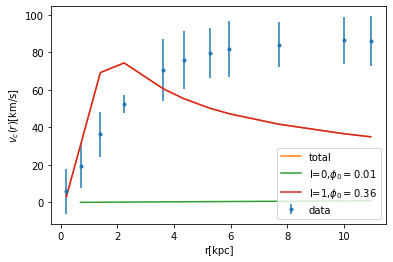

In [32]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0_01(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x),phi0_array[0],phi0_array[1]),label='total')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[1]),phi0_array[0],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[0]))
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[2]),phi0_array[1],f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_array[1]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='lower right')

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


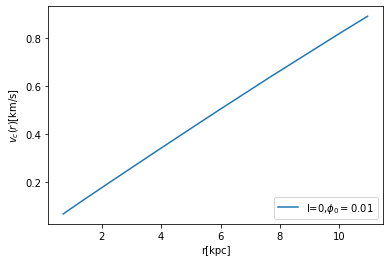

In [33]:
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[1]),phi0_array[0],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[0]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='lower right')

# taking $m_{a}$ as a constant

In [36]:
def Vc_eps_phi0_01(r,params,phi0_0,phi0_1):
    eps0,eps1 = params
    Vc2 = Vc_xi2_phi(r,m_a_l0,eps0,phi0_0,f0,u_0,l=0.) + Vc_xi2_phi(r,m_a_l0,eps1,phi0_1,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [37]:
def Xi2_eps_phi01_ESO3020120(params,phi00,phi01):
    eps0,eps1 = params
    par = np.exp(eps0),np.exp(eps1)
    model = Vc_eps_phi0_01(vecRp_ESO3020120,par,phi00,phi01)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [38]:
x0_eps_phi0_ESO3020120 = np.array([np.log(1.0e-4),np.log(1.0e-3)])
LS_eps_phi0_ESO3020120 = optimize.minimize(Xi2_eps_phi01_ESO3020120,x0_eps_phi0_ESO3020120,method='TNC',bounds=((np.log(1.0e-5),np.log(1.)),(np.log(1.0e-5),np.log(1.)),),args=(phi0_array[2],phi0_array[1]))
print(LS_eps_phi0_ESO3020120)

     fun: 19.131296826676078
     jac: array([0.00054783, 0.002116  ])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 261
     nit: 19
  status: 1
 success: True
       x: array([-11.18471009,  -7.41278032])


In [40]:
np.exp(LS_eps_phi0_ESO3020120.x)

array([1.38848798e-05, 6.03490462e-04])

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


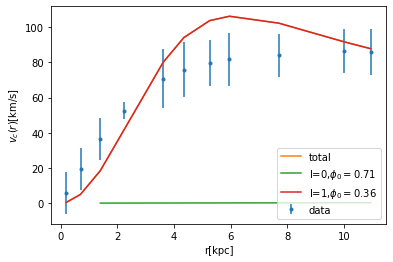

In [48]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,Vc_eps_phi0_01(vecRp_ESO3020120,np.exp(LS_eps_phi0_ESO3020120.x),phi0_array[2],phi0_array[1]),label='total')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,m_a_l0,np.exp(LS_eps_phi0_ESO3020120.x[0]),phi0_array[2],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[2]))
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,m_a_l0,np.exp(LS_eps_phi0_ESO3020120.x[1]),phi0_array[1],f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_array[1]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='lower right')

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


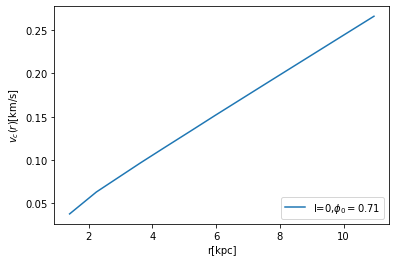

In [50]:
#plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,m_a_l0,np.exp(LS_eps_phi0_ESO3020120.x[0]),phi0_array[2],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[2]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='lower right')

In [51]:
r_test = np.linspace(vecRp_ESO3020120[0],vecRp_ESO3020120[-1],30)

In [52]:
Vc2_test = Vc_xy_phi(r_test,m_a_l0,3.5e-4,0.5,f0,u_0,l=0.)

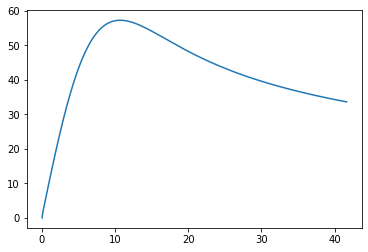

In [54]:
plt.plot(Vc2_test[0],np.sqrt(Vc2_test[1]))

In [55]:
Vc2_test2 = Vc_xi2_phi(r_test,m_a_l0,3.5e-4,0.5,f0,u_0,l=0.)

(0.0, 10.95)

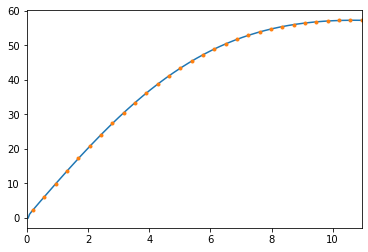

In [58]:
plt.plot(Vc2_test[0],np.sqrt(Vc2_test[1]))
plt.plot(r_test,np.sqrt(Vc2_test2),'.')
plt.xlim(0.,vecRp_ESO3020120[-1])

In [59]:
phi0_array[2]

0.71

In [60]:
vc2_test4 = Vc_xy_phi(vecRp_ESO3020120,m_a_l0,1.38848798e-05,phi0_array[2],f0,u_0,l=0.)

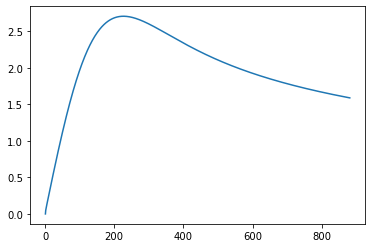

In [61]:
plt.plot(vc2_test4[0],np.sqrt(vc2_test4[1]))

In [62]:
Vc2_test4 = Vc_xi2_phi(vecRp_ESO3020120,m_a_l0,1.38848798e-05,phi0_array[2],f0,u_0,l=0.)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


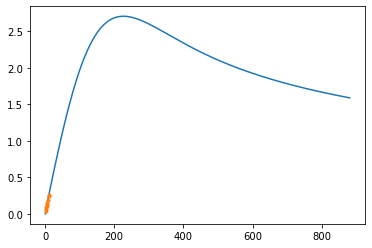

In [65]:
plt.plot(vc2_test4[0],np.sqrt(vc2_test4[1]))
plt.plot(vecRp_ESO3020120,np.sqrt(Vc2_test4),'.')
#plt.xlim(0.,vecRp_ESO3020120[-1])

# with other values of $\phi_{0}$

In [69]:
x0_eps_phi0_ESO3020120_ = np.array([np.log(1.0e-3),np.log(1.0e-3)])
LS_eps_phi0_ESO3020120_ = optimize.minimize(Xi2_eps_phi01_ESO3020120,x0_eps_phi0_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-4),np.log(1.0e-2)),(np.log(1.0e-5),np.log(1.)),),args=(phi0_array[2],phi0_array[0]))
print(LS_eps_phi0_ESO3020120_)

      fun: 19.29257155560639
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.15016609e-01, -1.42108548e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 14
     njev: 18
   status: 0
  success: True
        x: array([-9.21034037, -6.22019223])


In [70]:
np.exp(LS_eps_phi0_ESO3020120_.x)

array([0.0001    , 0.00198886])

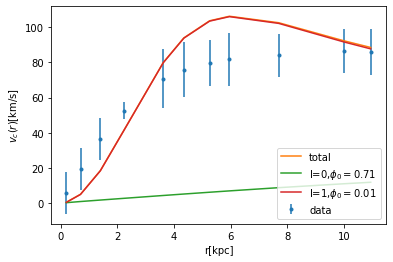

In [71]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,Vc_eps_phi0_01(vecRp_ESO3020120,np.exp(LS_eps_phi0_ESO3020120_.x),phi0_array[2],phi0_array[0]),label='total')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,m_a_l0,np.exp(LS_eps_phi0_ESO3020120_.x[0]),phi0_array[2],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[2]))
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,m_a_l0,np.exp(LS_eps_phi0_ESO3020120_.x[1]),phi0_array[0],f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_array[0]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='lower right')